In [44]:
from sklearn.feature_selection import SequentialFeatureSelector
from datasets import load_titanic, balance_classes
from tools import *
import pandas as pd
import numpy as np
from sklearn.metrics import plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
import plotly.express as px
from sklearn.metrics import classification_report, plot_roc_curve


In [6]:
df, df_train, df_test = load_titanic()
df_train.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'target'], dtype='object')

In [7]:
original_X = df.drop(['target'], axis=1)
original_y = df['target']
train_X = df_train.drop(['target'], axis=1)
train_y = df_train['target']
test_X = df_test.drop(['target'], axis=1)
test_y = df_test['target']

In [8]:
original_X = pd.get_dummies(original_X)
train_X = pd.get_dummies(train_X)
test_X = pd.get_dummies(test_X)

features = train_X.columns

In [9]:
scaler = StandardScaler().fit(train_X)
original_X = scaler.transform(original_X)
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

original_X = pd.DataFrame(original_X, columns=features)
train_X = pd.DataFrame(train_X, columns=features)
test_X = pd.DataFrame(test_X, columns=features)

## Forward selection

In [71]:
model = LogisticRegression(penalty='none')

In [72]:
scores = []

for i in range(1,len(features)):
    selection_forward = SequentialFeatureSelector(model, n_features_to_select=i, direction='forward').fit(original_X, original_y)

    selected_features = train_X.columns[selection_forward.get_support()]
    scores.append(cross_val_score(model, original_X[selected_features], original_y, cv=10).mean())

result = pd.DataFrame(zip(range(1, len(features)), scores), columns=['n of features', 'accuracy (mean)'])
px.line(result, x='n of features', y='accuracy (mean)')

In [73]:
selection_forward = SequentialFeatureSelector(model, n_features_to_select=3, direction='forward').fit(original_X, original_y)

In [74]:
# to je zajimave, dle koeficientu sibsp ani patch neni tak podstatne
selected_features = features[selection_forward.get_support()]
selected_features

Index(['pclass', 'sibsp', 'sex_female'], dtype='object')

In [75]:
# stratified (balanced), 5-fold
cross_val_score(model, original_X[selected_features], original_y).mean()

0.7990898248697508

In [76]:
model = model.fit(train_X[selected_features], train_y)

In [90]:
model.classes_

array([0, 1])

In [77]:
model_performance(model, train_X[selected_features], train_y, test_X[selected_features], test_y)

Train score
0.848314606741573
Test score
0.7769985974754559


In [78]:
confusion_matrix(model.predict(train_X[selected_features]), train_y, model.predict(test_X[selected_features]), test_y)

Train
TN: 89, TP: 62, FN: 17, FP: 10
Test
TN: 383, TP: 171, FN: 92, FP: 67


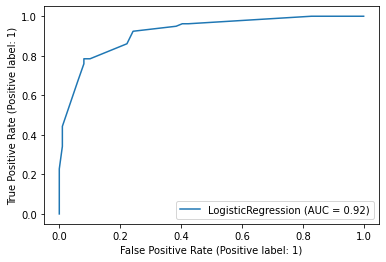

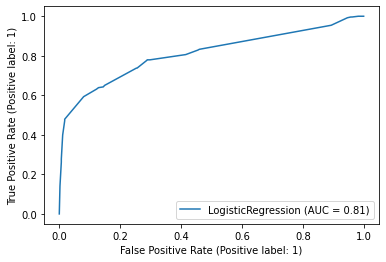

In [79]:
plot_roc_curve(model, train_X[selected_features], train_y)
plot_roc_curve(model, test_X[selected_features], test_y)

In [80]:
pd.DataFrame(zip(model.coef_[0], selected_features), columns=['coef', 'features'])

,coef,features
0,-1.213918,pclass
1,-0.252213,sibsp
2,2.164885,sex_female


## Backward selection

In [81]:
scores = []

for i in range(1,len(features)):
    selection_forward = SequentialFeatureSelector(model, n_features_to_select=i, direction='backward').fit(original_X, original_y)

    selected_features = train_X.columns[selection_forward.get_support()]
    scores.append(cross_val_score(model, original_X[selected_features], original_y, cv=10).mean())

result = pd.DataFrame(zip(range(1, len(features)), scores), columns=['n of features', 'accuracy (mean)'])
px.line(result, x='n of features', y='accuracy (mean)')

In [82]:
selection_backward = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=5, direction='backward').fit(original_X, original_y)

In [83]:
# uplne jiny vysledek
selected_features = features[selection_backward.get_support()]
selected_features

Index(['pclass', 'age', 'sibsp', 'sex_male', 'embarked_S'], dtype='object')

In [84]:
# stratified (balanced), 5-fold
cross_val_score(LogisticRegression(), original_X[selected_features], original_y).mean()

0.7946142740568704

In [85]:
model = model.fit(train_X[selected_features], train_y)

In [86]:
model_performance(model, train_X[selected_features], train_y, test_X[selected_features], test_y)

Train score
0.848314606741573
Test score
0.7769985974754559


In [87]:
confusion_matrix(model.predict(train_X[selected_features]), train_y, model.predict(test_X[selected_features]), test_y)

Train
TN: 83, TP: 68, FN: 11, FP: 16
Test
TN: 368, TP: 186, FN: 77, FP: 82


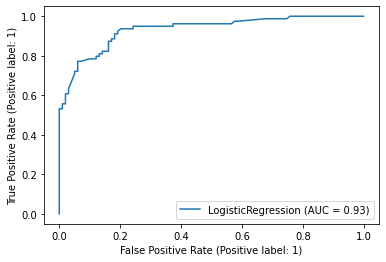

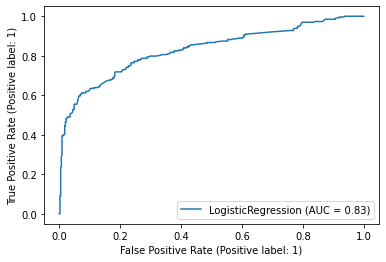

In [88]:
plot_roc_curve(model, train_X[selected_features], train_y)
plot_roc_curve(model, test_X[selected_features], test_y)